This Jupyter notebook demonstrates the implementation of dimensionality reduction techniques such as PCA and t-SNE on genotype data sourced from the [1000 Genomes Project](https://www.internationalgenome.org/category/vcf/). \
Specifically, the analysis focuses on 22 chromosome data.

The VCF, TBI and PANEL files are available at the following [link](https://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20110521/). \
The VCF file encompasses genotype information, while the PANEL file includes sample IDs and their corresponding population codes. \
Additionally, the TSV file, containing population information, can be downloaded from [here](https://www.internationalgenome.org/data-portal/population).

**Table of Contents:**

1. Data Loading and Preprocessing
    - Load Genotypes
    - Load Population Information
2. Run PCA on Genotypes
3. Create Dataframe for Visualizations
4. Visualizations
    - PCA
    - t-SNE
5. PCA on Variants

In [1]:
from typing import Optional

import numpy as np

import pandas as pd
from sklearn import decomposition
from sklearn.manifold import TSNE
from pysam import VariantFile, VariantHeader

import matplotlib.pyplot as plt
import seaborn as sns

## 1. Data Loading and Preprocessing

In [2]:
data_path = "data"

In [3]:
vcf_filename = data_path + "/" + "ALL.chr22.phase1_release_v3.20101123.snps_indels_svs.genotypes.vcf.gz"
panel_filename = data_path + "/" + "phase1_integrated_calls.20101123.ALL.panel"
population_file = data_path + "/" + "igsr_populations.tsv"

### 1.1 Load Genotypes

In [4]:
with VariantFile(vcf_filename) as vcf_file:
    n_samples = len(vcf_file.header.samples)
    sample_ids =  [vcf_file.header.samples[i] for i in range(n_samples)]

[W::bcf_hdr_check_sanity] GL should be declared as Number=G


In [5]:
print("Number of samples:", n_samples)
print(sample_ids[:5])

Number of samples: 1092
['HG00096', 'HG00097', 'HG00099', 'HG00100', 'HG00101']


In [6]:
genotypes = []
variant_ids = []

with VariantFile(vcf_filename) as vcf_file:
    for counter, record in enumerate(vcf_file):
        # we take only one SNP for every 100 SNPs as nearby SNPs 
        # often exhibit correlation and demonstrate similar trends
        if counter % 100 == 0:
            alleles = [record.samples[sample_id].allele_indices for sample_id in record.samples]

            genotypes.append(alleles)
            variant_ids.append(record.id)

In [7]:
len(genotypes), len(genotypes[0])

(4944, 1092)

In [8]:
variant_ids[:5]

['rs149201999', 'rs148791235', 'rs150417216', 'rs76462367', 'rs142219942']

In [9]:
genotypes = np.array(genotypes)
genotypes.shape

(4944, 1092, 2)

In [10]:
genotypes[0][:5]

array([[0, 0],
       [0, 1],
       [0, 1],
       [0, 0],
       [0, 1]])

In [11]:
genotypes = np.count_nonzero(genotypes, axis=2)
genotypes.shape

(4944, 1092)

In [12]:
genotypes = genotypes.T
genotypes.shape

(1092, 4944)

### 1.2 Load Population Information

In [13]:
sample_id_col, population_code_col = [], []

with open(panel_filename) as panel_file:
    for line in panel_file:
        cur_line = line.strip().split("\t")
        
        sample_id_col.append(cur_line[0])
        population_code_col.append(cur_line[1])

In [14]:
len(sample_id_col), len(population_code_col)

(1092, 1092)

In [15]:
labels = pd.DataFrame(data={"Sample ID": sample_id_col, 
                            "Population code": population_code_col})
labels.shape

(1092, 2)

In [16]:
labels.head(3)

,Sample ID,Population code
0,HG00096,GBR
1,HG00097,GBR
2,HG00099,GBR


In [17]:
populations = pd.read_csv(population_file, sep="\t")
populations.shape

(212, 11)

In [18]:
populations.head()

,Population code,Population elastic ID,Population name,Population description,Population latitude,Population longitude,Superpopulation code,Superpopulation name,Superpopulation display colour,Superpopulation display order,Data collections
0,FIN,FIN,Finnish,Finnish in Finland,60.17000,24.930000,EUR,European Ancestry,#018ead,4,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
1,CHS,CHS,Southern Han Chinese,Han Chinese South,23.13333,113.266667,EAS,East Asian Ancestry,#778500,3,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
2,KHV,KHV,Kinh Vietnamese,"Kinh in Ho Chi Minh City, Vietnam",10.78000,106.680000,EAS,East Asian Ancestry,#778500,3,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
3,BEB,BEB,Bengali,Bengali in Bangladesh,23.70000,90.350000,SAS,South Asian Ancestry,#c44cfd,5,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
4,PUR,PUR,Puerto Rican,Puerto Rican in Puerto Rico,18.40000,-66.100000,AMR,American Ancestry,#710027,2,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."


In [19]:
labels = labels.merge(populations, on="Population code", how="inner")
labels.shape

(1092, 12)

In [20]:
labels.head(3)

,Sample ID,Population code,Population elastic ID,Population name,Population description,Population latitude,Population longitude,Superpopulation code,Superpopulation name,Superpopulation display colour,Superpopulation display order,Data collections
0,HG00096,GBR,GBR,British,British in England and Scotland,52.486243,-1.890401,EUR,European Ancestry,#018ead,4,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
1,HG00097,GBR,GBR,British,British in England and Scotland,52.486243,-1.890401,EUR,European Ancestry,#018ead,4,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
2,HG00099,GBR,GBR,British,British in England and Scotland,52.486243,-1.890401,EUR,European Ancestry,#018ead,4,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."


## 2. Run PCA on Genotypes

In [21]:
pca = decomposition.PCA(n_components=2)

In [22]:
pca.fit(genotypes)

PCA(n_components=2)

In [23]:
pca.explained_variance_ratio_

array([0.08090641, 0.05957693])

In [24]:
pca.singular_values_

array([191.70412886, 164.50498454])

In [25]:
pca_data = pca.transform(genotypes)
pca_data.shape

(1092, 2)

In [26]:
pca_data[:5,]

array([[-0.57357175, -5.69582831],
       [-1.08247578, -6.67670136],
       [-0.40257583, -5.05267267],
       [ 0.14423053, -7.09984663],
       [-0.94105649, -4.21141793]])

## 3. Create Dataframe for Visualizations

In [27]:
df = pd.DataFrame(pca_data, columns=["PC1", "PC2"])
df.shape

(1092, 2)

In [28]:
df.head()

,PC1,PC2
0,-0.573572,-5.695828
1,-1.082476,-6.676701
2,-0.402576,-5.052673
3,0.144231,-7.099847
4,-0.941056,-4.211418


In [29]:
df["Sample ID"] = sample_ids

In [30]:
df.head()

,PC1,PC2,Sample ID
0,-0.573572,-5.695828,HG00096
1,-1.082476,-6.676701,HG00097
2,-0.402576,-5.052673,HG00099
3,0.144231,-7.099847,HG00100
4,-0.941056,-4.211418,HG00101


In [31]:
df = df.merge(labels, on="Sample ID", how="inner")
df.shape

(1092, 14)

In [32]:
df.head()

,PC1,PC2,Sample ID,Population code,Population elastic ID,Population name,Population description,Population latitude,Population longitude,Superpopulation code,Superpopulation name,Superpopulation display colour,Superpopulation display order,Data collections
0,-0.573572,-5.695828,HG00096,GBR,GBR,British,British in England and Scotland,52.486243,-1.890401,EUR,European Ancestry,#018ead,4,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
1,-1.082476,-6.676701,HG00097,GBR,GBR,British,British in England and Scotland,52.486243,-1.890401,EUR,European Ancestry,#018ead,4,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
2,-0.402576,-5.052673,HG00099,GBR,GBR,British,British in England and Scotland,52.486243,-1.890401,EUR,European Ancestry,#018ead,4,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
3,0.144231,-7.099847,HG00100,GBR,GBR,British,British in England and Scotland,52.486243,-1.890401,EUR,European Ancestry,#018ead,4,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
4,-0.941056,-4.211418,HG00101,GBR,GBR,British,British in England and Scotland,52.486243,-1.890401,EUR,European Ancestry,#018ead,4,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."


In [ ]:
df.to_csv(data_path + "/" + "pca.csv")

## 4. Visualizations

In [33]:
def scatter_plot(df: pd.DataFrame, x_axis: str, y_axis: str, 
                 x_label: str, y_label: str, 
                 hue: Optional[str]=None, style: Optional[str]=None, 
                 palette="hls", legend=True):
    if not hue:
        palette = None
    
    plt.figure(figsize=(10, 6))

    sns.scatterplot(x=x_axis, y=y_axis, data=df, hue=hue, style=style, 
                    palette=palette, edgecolor="black", alpha=0.7)

    plt.xlabel(x_label, fontsize=10, fontweight="bold")
    plt.ylabel(y_label, fontsize=10, fontweight="bold")
    if legend:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    plt.show()

### 4.1 PCA

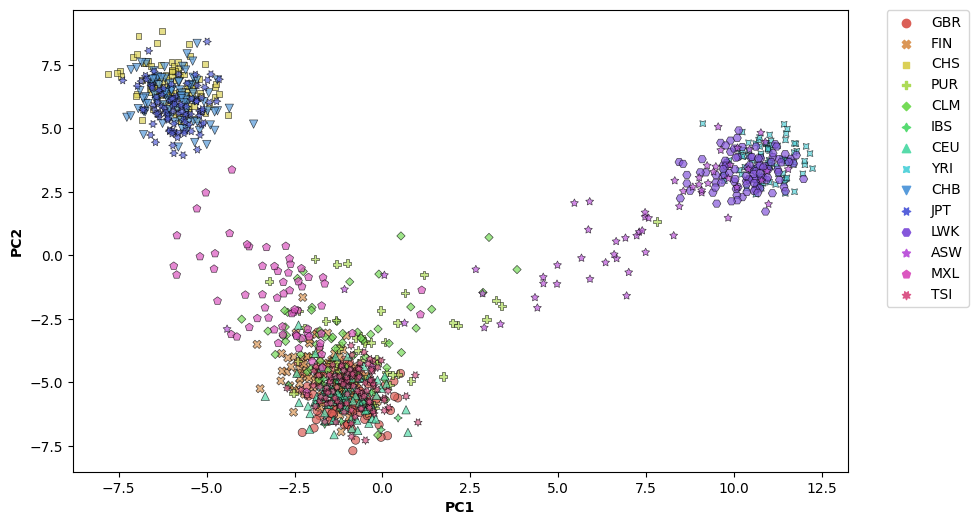

In [34]:
scatter_plot(df, x_axis="PC1", y_axis="PC2", x_label="PC1", y_label="PC2", 
             hue="Population code", style="Population code")

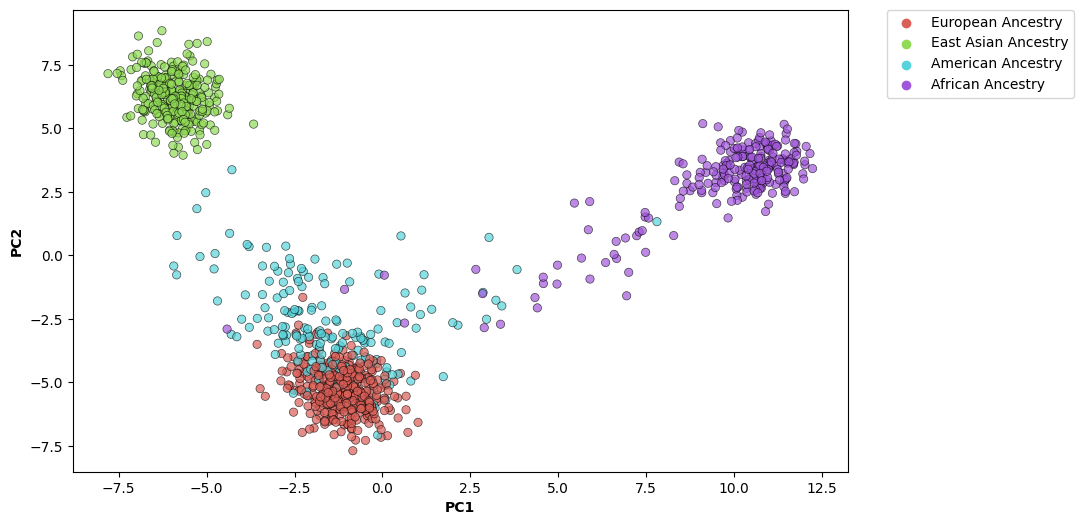

In [35]:
scatter_plot(df, x_axis="PC1", y_axis="PC2", x_label="PC1", y_label="PC2", 
             hue="Superpopulation name")

### 4.2 t-SNE

In [36]:
X_embedded = TSNE(n_components=2, learning_rate="auto", 
                  init="random").fit_transform(genotypes)

In [37]:
X_embedded.shape

(1092, 2)

In [38]:
df["TSNE_1"] = X_embedded[:,0]
df["TSNE_2"] = X_embedded[:,1]
df.shape

(1092, 16)

In [39]:
df.head(3)

,PC1,PC2,Sample ID,Population code,Population elastic ID,Population name,Population description,Population latitude,Population longitude,Superpopulation code,Superpopulation name,Superpopulation display colour,Superpopulation display order,Data collections,TSNE_1,TSNE_2
0,-0.573572,-5.695828,HG00096,GBR,GBR,British,British in England and Scotland,52.486243,-1.890401,EUR,European Ancestry,#018ead,4,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC...",-26.439032,-11.581766
1,-1.082476,-6.676701,HG00097,GBR,GBR,British,British in England and Scotland,52.486243,-1.890401,EUR,European Ancestry,#018ead,4,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC...",-22.193201,-4.409508
2,-0.402576,-5.052673,HG00099,GBR,GBR,British,British in England and Scotland,52.486243,-1.890401,EUR,European Ancestry,#018ead,4,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC...",-10.746448,-3.386275


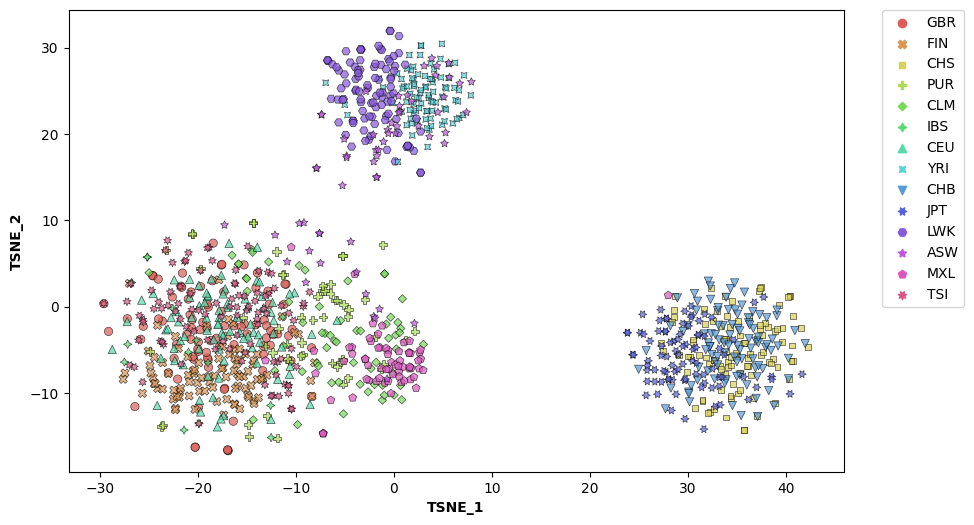

In [40]:
scatter_plot(df, x_axis="TSNE_1", y_axis="TSNE_2", 
             x_label="TSNE_1", y_label="TSNE_2", 
             hue="Population code", style="Population code")

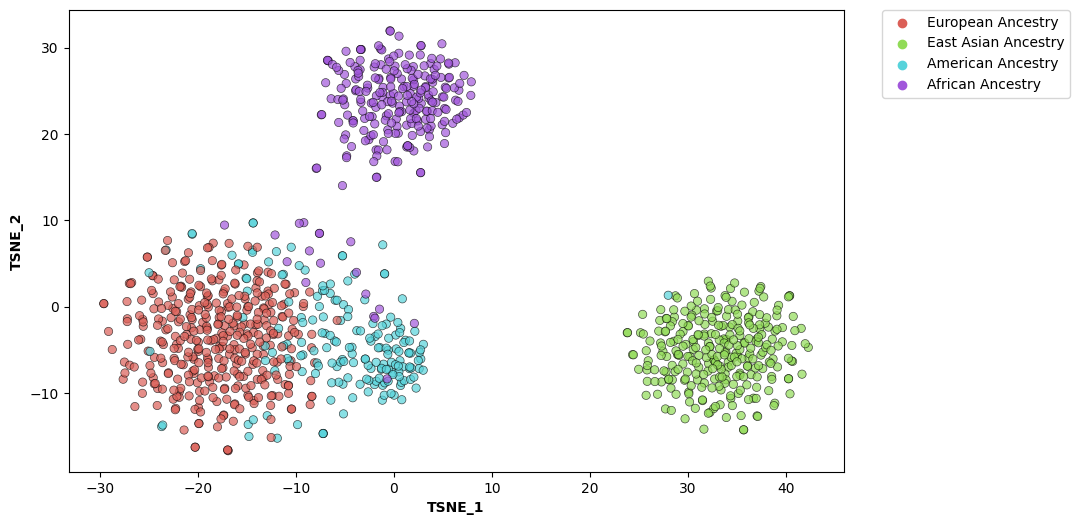

In [41]:
scatter_plot(df, x_axis="TSNE_1", y_axis="TSNE_2", 
             x_label="TSNE_1", y_label="TSNE_2", 
             hue="Superpopulation name", style=None)

## 5. PCA on Variants

In [42]:
X = genotypes.T

In [43]:
pca = decomposition.PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

In [44]:
pca_data = pca.transform(X)
pca_data.shape

(4944, 2)

In [45]:
variants_df = pd.DataFrame(pca_data, columns=["PC1", "PC2"])
variants_df.shape

(4944, 2)

In [46]:
variants_df.head(3)

,PC1,PC2
0,-1.105754,0.672986
1,-1.762707,-0.885698
2,-4.805219,0.079348


In [47]:
variants_df["Variant ID"] = variant_ids
variants_df.head(3)

,PC1,PC2,Variant ID
0,-1.105754,0.672986,rs149201999
1,-1.762707,-0.885698,rs148791235
2,-4.805219,0.079348,rs150417216


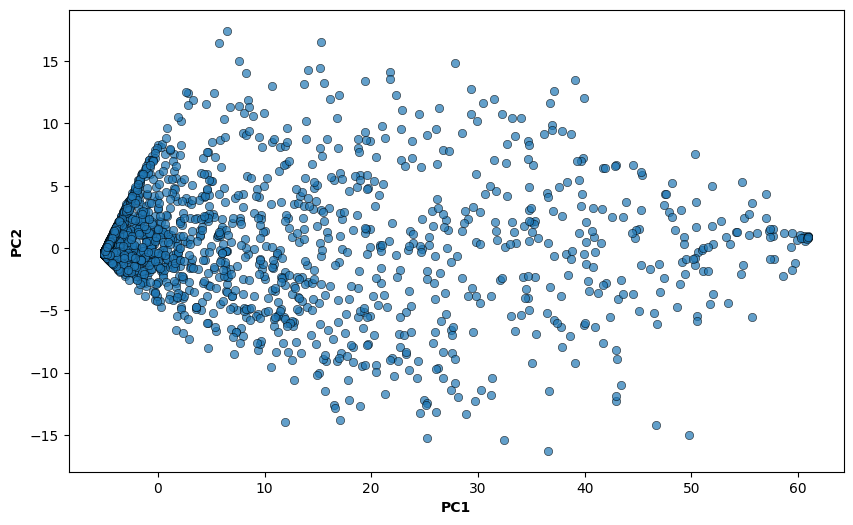

In [48]:
scatter_plot(variants_df, x_axis="PC1", y_axis="PC2", 
             x_label="PC1", y_label="PC2", legend=False)